# Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [16]:
import os
os.chdir("/home2/jgcw74/l3_project")  # go to project root
import importlib

import helpers
import dataset_processing
import models
import xai
from evaluate_xai import correctness, output_completeness, deletion

torch_device = helpers.utils.get_torch_device()

In [4]:
import typing as t
from pathlib import Path
import json

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
AVAILABLE_MODELS = ("ConvNeXtSmall", "ResNet50", "SwinTransformerSmall")

np.set_printoptions(precision=4, threshold=100, floatmode="fixed", suppress=True)

# Helper functions

In [6]:
def get_dataset_and_model(dataset_n: dataset_processing.DATASET_NAMES, model_n: models.MODEL_NAMES):
    model_type = models.get_model_type(model_n)
    ds = dataset_processing.get_dataset_object(dataset_n, "test", model_type.expected_input_dim, 32, 4, torch_device)

    m = model_type(False, ds.N_BANDS, ds.N_CLASSES).to(torch_device).eval()
    weights_path = json.load(Path("weights_paths.json").open("r"))[dataset_n][model_n]
    m.load_weights(Path("checkpoints") / dataset_n / model_n / weights_path)

    return ds, m

# Other figures

## Deletion visualisation

In [ ]:
dataset_name = "PatternNet"
dataset, _ = get_dataset_and_model(dataset_name, "SwinTransformerSmall")

In [ ]:
print(list(enumerate(dataset.classes)))

In [ ]:
imgs = [dataset[i]["image"] for i in np.random.default_rng(42).choice([idx for idx, (_, c) in enumerate(dataset.imgs) if c==37], size=8)]
helpers.plotting.show_image(torch.stack(imgs))

In [ ]:
selected_img = imgs[1].to(torch_device)

In [ ]:
from evaluate_xai import deletion

In [ ]:
random_deletion = deletion.generate_random_ranking((selected_img.shape[-2], selected_img.shape[-1]), 8, 42)
plt.matshow(random_deletion)

In [ ]:
importlib.reload(deletion)
k = 0.6 * selected_img.shape[-1] * selected_img.shape[-2]
deleted_imgs = [selected_img.cpu()]
for method in (0, np.random.default_rng(42), "blur", "inpaint", "nn", "shuffle"):
    deletion_output = torch.from_numpy(deletion.delete_top_k_important(
        selected_img.unsqueeze(0), random_deletion[None, :], k, method
    ))
    deleted_imgs.append(deletion_output[0])

In [ ]:
helpers.plotting.show_image(torch.stack(deleted_imgs, dim=0), padding_value=1)
plt.gcf().set_dpi(200)

## Dataset samples

In [ ]:
np_rng = np.random.default_rng(43)

selected_imgs = [[] for _ in range(3)]
eurosat, _ = get_dataset_and_model("EuroSATRGB", "SwinTransformerSmall")
print(list(enumerate(eurosat.classes)))

In [ ]:
for c in [i for i in range(10) if i != 3]:
    c_idxs = [i for i, (_, class_) in enumerate(eurosat.imgs) if class_ == c]
    selected_is = np_rng.choice(c_idxs, 1, replace=False)
    print(selected_is)
    selected_imgs[0] += [eurosat[i]["image"] for i in selected_is]
desired_order = [1, 3, 7, 0, 2, 4, 5, 6, 8]
selected_imgs[0] = [selected_imgs[0][i] for i in desired_order]

In [ ]:
ucm, _ = get_dataset_and_model("UCMerced", "SwinTransformerSmall")
print(list(enumerate(ucm.classes)))

In [ ]:
for c in [1,2,3,6,18,11,10,16,20]:
    c_idxs = [i for i, (_, class_) in enumerate(ucm.imgs) if class_ == c]
    selected_is = np_rng.choice(c_idxs, 1, replace=False)
    selected_imgs[1] += [ucm[i]["image"] for i in selected_is]

In [ ]:
pn, _ = get_dataset_and_model("PatternNet", "SwinTransformerSmall")
print(list(enumerate(pn.classes)))

In [ ]:
for c in [2,13,4,7,31,9,32,11,27]:
    c_idxs = [i for i, (_, class_) in enumerate(pn.imgs) if class_ == c]
    selected_is = np_rng.choice(c_idxs, 1, replace=False)
    selected_imgs[2] += [pn[i]["image"] for i in selected_is]

In [ ]:
# fig, ax = plt.subplots(1, 3)  # type: plt.Figure, list[plt.Axes]
for i in range(3):
    helpers.plotting.show_image(torch.stack(selected_imgs[i], dim=0), padding_value=1, imgs_per_row=3)
    plt.show()

In [ ]:
ms, _ = get_dataset_and_model("EuroSATMS", "SwinTransformerSmall")

In [ ]:
", ".join([f'“{b}”' for b in ms.bands])

In [ ]:
helpers.plotting.show_ms_images(torch.stack([ms[992]["image"], ms[2294]["image"], ms[4705]["image"]]),
                                normalisation_type="channel", total_fig_size=(10, 3), img_stacking="vertical", show_indices=False)

## EuroSAT intra-class variation and inter-class similarity

In [ ]:
print(list(enumerate(eurosat.classes)))

In [ ]:
np_rng = np.random.default_rng(27)
fig_imgs = []
c_idxs = [i for i, (_, class_) in enumerate(eurosat.imgs) if class_ == 3]
selected_is = np_rng.choice(c_idxs, 4, replace=False)
c_idxs = [i for i, (_, class_) in enumerate(eurosat.imgs) if class_ == 5]
selected_is = np.append(selected_is, np_rng.choice(c_idxs, 2, replace=False))
c_idxs = [i for i, (_, class_) in enumerate(eurosat.imgs) if class_ == 7]
selected_is = np.append(selected_is, np_rng.choice(c_idxs, 2, replace=False))
print(selected_is)
fig_imgs += [eurosat[i]["image"] for i in selected_is]
helpers.plotting.show_image(torch.stack(fig_imgs), padding_value=1, imgs_per_row=4, padding=20)

## Front page example

In [ ]:
from evaluate_xai import correctness
import pandas as pd

In [ ]:
dataset_name = "EuroSATRGB"
model_name = "ConvNeXtSmall"
ds, model = get_dataset_and_model(dataset_name, model_name)

In [ ]:
class_idx = 6  # PermanentCrop
batch_num = 1

In [ ]:
exps = []
for e_name in t.get_args(xai.EXPLAINER_NAMES):
    exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
    )
    exp.force_load()
    exps.append(exp)

In [ ]:
helpers.plotting.show_image(exps[0].input.cpu(), padding_value=1)
plt.show()
for exp in exps:  # type: xai.Explainer
    helpers.plotting.visualise_importance(exp.input.cpu(), exp.ranked_explanation, alpha=0.4, with_colorbar=False)
    plt.show()

In [ ]:
desired_i = -4
original_img = torch.stack([exps[0].input[desired_i] for _ in range(3)])
selected_exps = np.stack([exp.explanation[desired_i] for exp in exps])

In [ ]:
new_combined_exp = xai.get_explainer_object(
    "GradCAM", model, extra_path=Path("testing"),
)
new_combined_exp.input = original_img
new_combined_exp.explanation = selected_exps
helpers.plotting.visualise_importance(new_combined_exp.input.cpu(), new_combined_exp.ranked_explanation, alpha=0.4, with_colorbar=False)

In [ ]:
return_data = correctness.Correctness(new_combined_exp).evaluate(
    "incremental_deletion", deletion_method="shuffle",
    visualise=True, full_data=True,
)

In [ ]:
conf_with_exp_del = return_data["informed_full"]
conf_with_rand_del = return_data["random_full"].mean(axis=0)
random_deleted_imgs = return_data["random_deleted_imgs"]
informed_deleted_imgs = return_data["informed_deleted_imgs"]
random_rankings = return_data["random_rankings"]

In [ ]:
return_data["informed"], return_data["random"].mean()

In [ ]:
df = pd.DataFrame(data=[*conf_with_exp_del, conf_with_rand_del], index=["PartitionSHAP", "Grad-CAM", "KPCA-CAM", "Randomised"])
df.index.name = "xAI Method"
ax = df.T.plot(
    kind="line", style=["b-", "g-", "r-", "k--"], marker="o",
    xlim=(3, 10), ylabel="Model confidence in original ($k=0$) class", ylim=(0, 1), xlabel="Deletion Iteration, $k$",
    figsize=(6, 4), grid=True, # title="Incremental Deletion Curves, $f_c(\mathbf{x}')$",
)
plt.gcf().set_dpi(200)

In [ ]:
random_deleted_imgs.shape

In [ ]:
key_deleted_imgs = np.stack([*informed_deleted_imgs[:, 6], random_deleted_imgs[0, 6]])
helpers.plotting.show_image(key_deleted_imgs, padding_value=1, padding=20, imgs_per_row=2)
plt.gcf().set_dpi(150)

In [ ]:
helpers.plotting.visualise_importance(
    new_combined_exp.input.cpu()[:1].repeat(4, 1, 1, 1),
    np.stack([*new_combined_exp.ranked_explanation, random_rankings[0].astype(int)]),
    alpha=1, with_colorbar=False, imgs_per_row=2,
)
plt.gcf().set_dpi(150)

In [ ]:
helpers.plotting.show_image(new_combined_exp.input.cpu()[:1], padding=20)
plt.gcf().set_dpi(100)

# Results visualisations

## Figure 1 - Model Randomisation - KPCACAM for ResNet50 on EuroSATMS

In [ ]:
dataset_name = "EuroSATMS"
dataset, model = get_dataset_and_model(dataset_name, "ResNet50")
print(list(enumerate(dataset.classes)))

In [ ]:
class_idx = 8  # (River, Forest and SeaLake all bad)
batch_num = 0
kpca_exp = xai.get_explainer_object(
    "KPCACAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
kpca_exp.force_load()

In [ ]:
helpers.plotting.show_image(kpca_exp.input[:8])

In [ ]:
for e_name in t.get_args(xai.EXPLAINER_NAMES):
    print(e_name)

    grad_exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
    )
    grad_exp.force_load()
    helpers.plotting.visualise_importance(dataset.inverse_transform(grad_exp.input[:8]).transpose(0, 3, 1, 2)*2-1,
                                          grad_exp.explanation[:8], alpha=0.5, final_fig_size=(10, 2.5),
                                          with_colorbar=False, show_samples_separate=True)
    plt.show()

    randomised_exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / "combined" / "randomised",
    )
    randomised_exp.force_load()
    helpers.plotting.visualise_importance(randomised_exp.input[:8].numpy(force=True),
                                          randomised_exp.explanation[:8],
                                          alpha=1., with_colorbar=False, band_idxs=dataset.rgb_indices)
    plt.show()

KPCACAM shows extremely similar explanations for the randomised model to those provided for the un-randomised model.

In [ ]:
transformed_imgs = dataset.inverse_transform(grad_exp.input).transpose(0, 3, 1, 2)*2-1

helpers.plotting.visualise_importance(np.concatenate((transformed_imgs[:8],)*2, axis=0),
                                      np.concatenate([grad_exp.explanation[:8], randomised_exp.explanation[:8]]),
                                      alpha=0.7, final_fig_size=(10, 2.5),
                                      with_colorbar=False, padding_value=1)
plt.gcf().set_dpi(150)
plt.show()

## Figure 2 - AuC - GradCAM is worse than random at identifying relevant pixels for PatternNet.River

In [ ]:
dataset_name = "PatternNet"
dataset, model = get_dataset_and_model(dataset_name, "ConvNeXtSmall")
print(list(enumerate(dataset.classes)))

In [ ]:
class_idx = 27  # "River"
batch_num = 1
shap_exp = xai.get_explainer_object(
    "PartitionSHAP", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
shap_exp.force_load()

In [ ]:
helpers.plotting.show_image(shap_exp.input[:8], padding=20, padding_value=1)

In [ ]:
for e_name in ("GradCAM", "KPCACAM"):
    print(e_name)

    grad_exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
    )
    grad_exp.force_load()
    helpers.plotting.visualise_importance(grad_exp.input[:8], grad_exp.explanation[:8],
                                          alpha=0.5, final_fig_size=(10, 2.2), padding_value=1,
                                          with_colorbar=False, band_idxs=dataset.rgb_indices, show_samples_separate=False)
    plt.show()

In [ ]:
cor_metric = correctness.Correctness(grad_exp, max_batch_size=8)
aocs = cor_metric.evaluate("incremental_deletion", deletion_method="shuffle", visualise=True)
print(np.mean(aocs["informed"] / aocs["random"]))

RE the confidence going back up again after initial deletions: it does kind of look more like an in-distribution river image again once there have been enough deletions (on both sides of the river bank). A sign that this metric maybe isn't the most suited to satellite imagery where large areas are important. In this case, it *has* successfully identified pixels; it's just that 'deleting' them has inadvertently led to a river-like image again.

In [ ]:
cor_metric2 = correctness.Correctness(shap_exp, max_batch_size=8)
aocs2 = cor_metric2.evaluate("incremental_deletion", deletion_method="shuffle", visualise=True)
print(np.mean(aocs2["informed"] / aocs2["random"]))

While the above is true, PartitionSHAP still manages to better on the same class of images so clearly it has identified the important locations better? PartitionSHAP is roughly on par with random.

## Figure 3 - Deletion/Preservation checks - Efficacy of deletion and preservation checks on UCMerced.Sparse Residential

In [ ]:
dataset_name = "UCMerced"
dataset, model = get_dataset_and_model(dataset_name, "ConvNeXtSmall")
print(list(enumerate(dataset.classes)))

In [ ]:
class_idx = 18  # "sparse residential"
batch_num = 0
grad_ucm_sr_exp = xai.get_explainer_object(
    "GradCAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
grad_ucm_sr_exp.force_load()

In [ ]:
helpers.plotting.show_image(grad_ucm_sr_exp.input[:8], padding=20, padding_value=1)

In [ ]:
helpers.plotting.visualise_importance(grad_ucm_sr_exp.input[:8], grad_ucm_sr_exp.explanation[:8],
                                      alpha=0.5, padding_value=1, with_colorbar=False)

In [ ]:
ocd_metric = output_completeness.OutputCompleteness(grad_ucm_sr_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="shuffle", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

### PatternNet.Freeway

In [ ]:
dataset_name = "PatternNet"
dataset, model = get_dataset_and_model(dataset_name, "ConvNeXtSmall")
print(list(enumerate(dataset.classes)))

In [ ]:
class_idx = 15  # "freeway"
batch_num = 1
kpca_pn_fw_exp = xai.get_explainer_object(
    "KPCACAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
kpca_pn_fw_exp.force_load()

In [ ]:
helpers.plotting.show_image(kpca_pn_fw_exp.input[:8], padding=20, padding_value=1)
plt.show()
helpers.plotting.visualise_importance(kpca_pn_fw_exp.input[:8], kpca_pn_fw_exp.explanation[:8],
                                      alpha=0.5, padding_value=0, with_colorbar=False)

In [ ]:
ocd_metric = output_completeness.OutputCompleteness(kpca_pn_fw_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="shuffle", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

For this class, the model is super sensitive to any changes to the input image it appears so informed and random deletion are on par. This is an excellent example of why you have to compare to random deletion to see if the explanation is good or the model is just sensitive.

In [ ]:
ocd_metric = output_completeness.OutputCompleteness(kpca_pn_fw_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="nn", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="nn", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

Note how different these results are when using a different deletion method, especially for preservation.

### EuroSAT.Highway

In [ ]:
dataset_name = "EuroSATRGB"
dataset, model = get_dataset_and_model(dataset_name, "ConvNeXtSmall")
print(list(enumerate(dataset.classes)))

In [ ]:
class_idx = 3  # "highway"
batch_num = 1
kpca_er_hw_exp = xai.get_explainer_object(
    "KPCACAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
kpca_er_hw_exp.force_load()

In [ ]:
helpers.plotting.show_image(kpca_er_hw_exp.input[:8], padding=20, padding_value=1)
plt.show()
helpers.plotting.visualise_importance(kpca_er_hw_exp.input[:8], kpca_er_hw_exp.explanation[:8],
                                      alpha=0.5, padding_value=0, with_colorbar=False)

In [ ]:
ocd_metric = output_completeness.OutputCompleteness(kpca_er_hw_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="shuffle", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

### Good vs poor explainer: UCMerced Mobile Home by KPCA vs PartitionSHAP

In [7]:
dataset_name = "UCMerced"
dataset, model = get_dataset_and_model(dataset_name, "SwinTransformerSmall")
print(list(enumerate(dataset.classes)))

[(0, 'agricultural'), (1, 'airplane'), (2, 'baseballdiamond'), (3, 'beach'), (4, 'buildings'), (5, 'chaparral'), (6, 'denseresidential'), (7, 'forest'), (8, 'freeway'), (9, 'golfcourse'), (10, 'harbor'), (11, 'intersection'), (12, 'mediumresidential'), (13, 'mobilehomepark'), (14, 'overpass'), (15, 'parkinglot'), (16, 'river'), (17, 'runway'), (18, 'sparseresidential'), (19, 'storagetanks'), (20, 'tenniscourt')]


In [ ]:
class_idx = 13  # "mobilehomepark"
batch_num = 0
kpca_bad_exp = xai.get_explainer_object(
    "KPCACAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
kpca_bad_exp.force_load()

In [ ]:
helpers.plotting.show_image(kpca_bad_exp.input[:8], padding=20, padding_value=1)
plt.show()
helpers.plotting.visualise_importance(kpca_bad_exp.input[:8], kpca_bad_exp.explanation[:8],
                                      alpha=0.5, padding_value=0, with_colorbar=False)

In [ ]:
ocd_metric = output_completeness.OutputCompleteness(kpca_bad_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="shuffle", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

The deletion of KPCACAM is far worse than random - it's not really reflecting the model's reasoning at all.

In [ ]:
ps_good_exp = xai.get_explainer_object(
    "PartitionSHAP", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
ps_good_exp.force_load()
helpers.plotting.show_image(ps_good_exp.input[:8], padding=20, padding_value=1)
plt.show()
helpers.plotting.visualise_importance(ps_good_exp.input[:8], ps_good_exp.explanation[:8],
                                      alpha=0.5, padding_value=0, with_colorbar=False)
plt.show()
ocd_metric = output_completeness.OutputCompleteness(ps_good_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="shuffle", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

PartitionSHAP also struggles to be much better than random but is at least positive...
It performs worse at preservation though.

### Preservation check visualisation for report

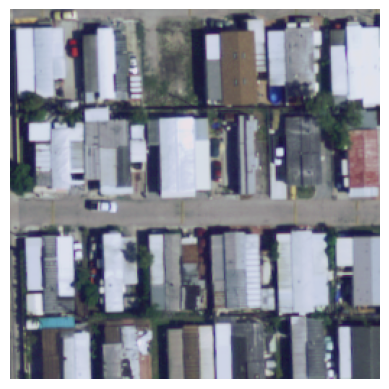

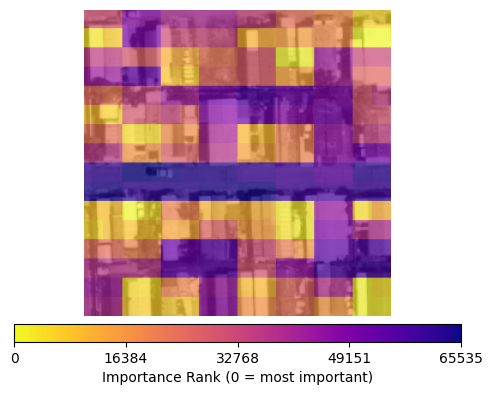

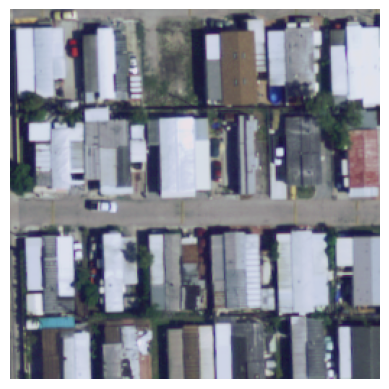

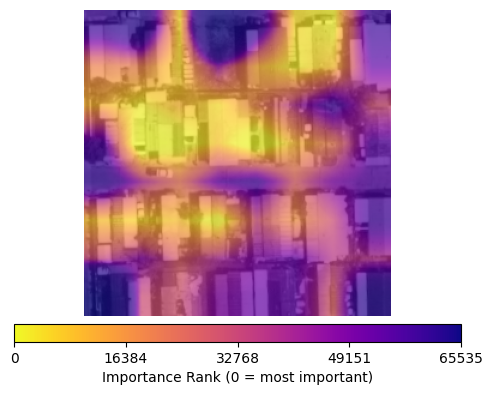

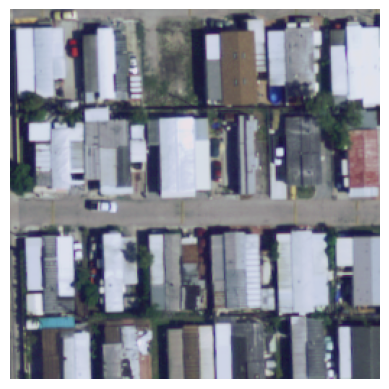

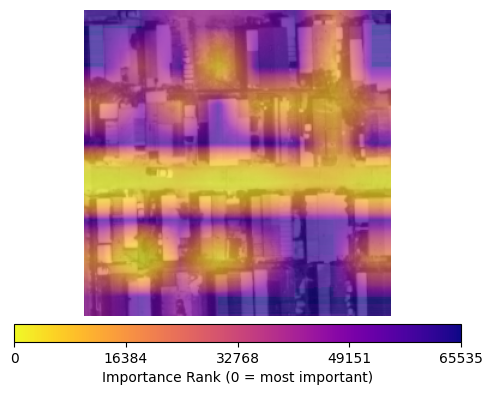

In [8]:
class_idx = 13  # "mobilehomepark"
batch_num = 0
exps = []
for ex_name in t.get_args(xai.EXPLAINER_NAMES):
    new_exp = xai.get_explainer_object(
        ex_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
    )

    new_exp.force_load()
    new_exp.input = new_exp.input[4:5]
    new_exp.explanation = new_exp.explanation[4:5]
    exps.append(new_exp)

    helpers.plotting.show_image(new_exp.input, padding=20, padding_value=1)
    plt.show()

    helpers.plotting.visualise_importance(new_exp.input, new_exp.ranked_explanation,
                                          alpha=0.7, padding_value=1, with_colorbar=True)
    plt.show()

PartitionSHAP


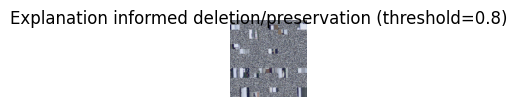

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

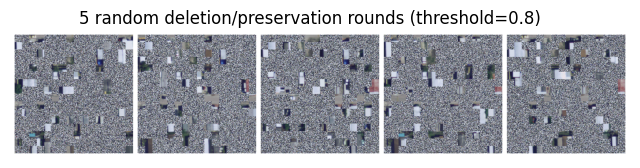

Predicting for OutputCompleteness:   0%|                                             | 0/1 [00:00<?, ?batch/s]

Original predictions (confidence): [13] ([[1.0000]])
Confidence after informed: [0.9864]
Confidence after random: [0.7843]
0.20209211
GradCAM


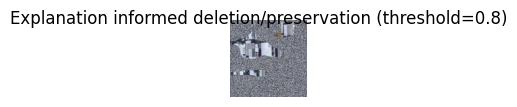

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

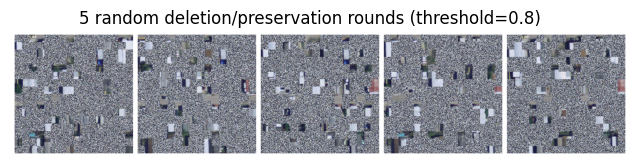

Predicting for OutputCompleteness:   0%|                                             | 0/1 [00:00<?, ?batch/s]

Original predictions (confidence): [13] ([[1.0000]])
Confidence after informed: [0.0102]
Confidence after random: [0.7355]
-0.72529864
KPCACAM


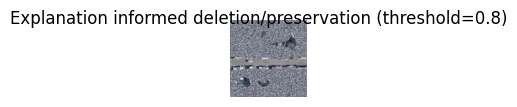

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

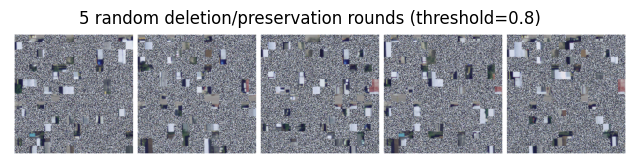

Predicting for OutputCompleteness:   0%|                                             | 0/1 [00:00<?, ?batch/s]

Original predictions (confidence): [13] ([[1.0000]])
Confidence after informed: [0.0005]
Confidence after random: [0.7030]
-0.7025096


In [9]:
pres_imgs = []
for exp in exps:
    print(exp.__class__.__name__)
    ocd_metric = output_completeness.OutputCompleteness(exp, max_batch_size=8)
    pres_check, imgs_tuple = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True, full_data=True)
    print(pres_check.mean())
    pres_imgs.append(imgs_tuple[0])
    rand_img = imgs_tuple[1][0]

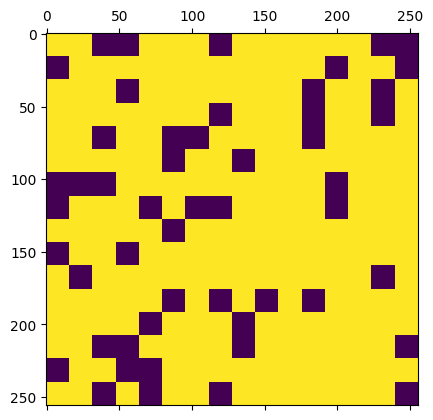

In [32]:
seed = np.random.default_rng(42).choice(10*5, 5, replace=False)[0]
random_rank = deletion.generate_random_ranking(
    exps[0].input.shape[-2:], 16, seed
).astype(int)
plt.matshow(random_rank < (0.8*exps[0].input.shape[-2]*exps[0].input.shape[-1]))

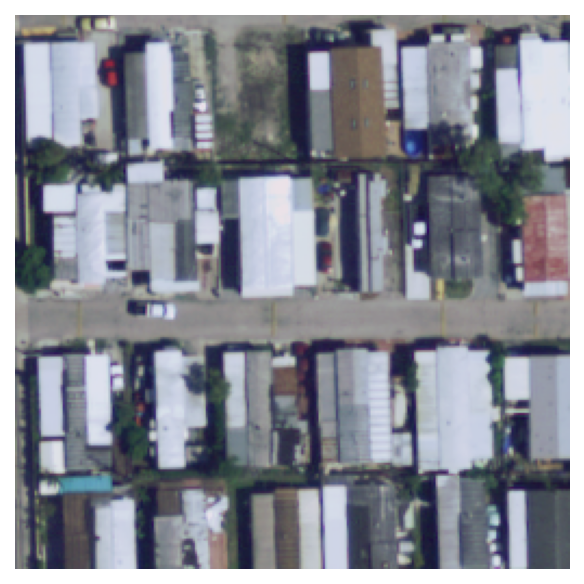

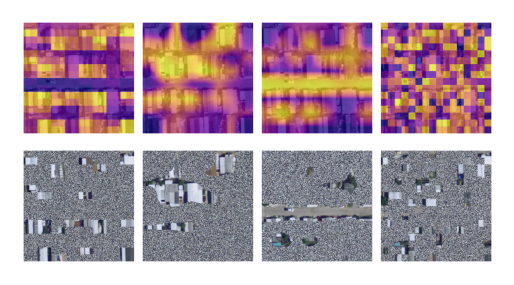

In [51]:
helpers.plotting.show_image(exp.input[:1].numpy(force=True), padding=40, padding_value=1)
plt.gcf().set_dpi(150)
plt.show()

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(4, 2), gridspec_kw={"hspace": 0})
helpers.plotting.visualise_importance(
    torch.concatenate([e.input for e in exps]+[exps[0].input]),
    np.concatenate([e.ranked_explanation for e in exps]+[random_rank[None,]]),
    ax=ax1, with_colorbar=False, alpha=0.7,
)
helpers.plotting.show_image(np.concatenate(pres_imgs+[rand_img]), padding=20, ax=ax2)
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.show()

## Figure 4 - Contrastivity - KPCA's explanations are very similar for adversarial examples

In [ ]:
from evaluate_xai import Similarity

In [ ]:
for exp_name in ("KPCACAM", "PartitionSHAP"):
    # print("===", exp_name)
    for dataset_name in ("EuroSATRGB", "PatternNet", "UCMerced"):
        # print("*", dataset_name)
        dataset, model = get_dataset_and_model(dataset_name, "SwinTransformerSmall")

        class_idx = 2 # np.random.default_rng(42).integers(0, len(dataset.classes))

        og_exp = xai.get_explainer_object(
            exp_name, model,
            extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{0:03}",
        )
        adv_exp = xai.get_explainer_object(
            exp_name, model,
            extra_path=Path(dataset_name) / f"c{class_idx:02}" / "combined" / "adversarial",
        )
        og_exp.force_load()
        adv_exp.force_load()

        # assert torch.equal(og_exp.input[:8], adv_exp.input[:8])
        # helpers.plotting.show_image(og_exp.input[:8], padding=20, padding_value=1)
        # plt.show()
        # helpers.plotting.show_image(adv_exp.input[:8], padding=20, padding_value=1)
        # plt.show()

        og_preds = model(og_exp.input[:8].to(torch_device)).argmax(1)
        adv_preds = model(adv_exp.input[:8].to(torch_device)).argmax(1)
        success_mask = og_preds != adv_preds
        success_mask = success_mask.cpu()

        relevant_input = og_exp.input[:8][success_mask]
        og_relevant_exp = og_exp.explanation[:8][success_mask]
        adv_relevant_exp = adv_exp.explanation[:8][success_mask]

        helpers.plotting.show_image(relevant_input, padding=20, padding_value=1)
        plt.show()
        print([dataset.classes[c] for c in adv_preds])

        helpers.plotting.visualise_importance(relevant_input, og_relevant_exp,
                                              alpha=0.8, padding_value=0, with_colorbar=True)
        plt.title(f"Original {exp_name} explanation on {dataset_name}.{dataset.classes[class_idx]}")
        plt.show()
        helpers.plotting.visualise_importance(relevant_input, adv_relevant_exp,
                                              alpha=0.8, padding_value=0, with_colorbar=True)
        plt.title(f"{exp_name} explanation on adversarial {dataset_name}.{dataset.classes[class_idx]}")
        plt.show()

        temp_exp1 = xai.get_explainer_object(exp_name, model)
        temp_exp1.explanation = og_relevant_exp
        temp_exp2 = xai.get_explainer_object(exp_name, model)
        temp_exp2.explanation = adv_relevant_exp
        print(Similarity(temp_exp1, temp_exp2)(intersection_k=np.floor(0.1*relevant_input.shape[-1]*relevant_input.shape[-2])))

KPCA explanations on adversarial examples are virtually identical to those on the original examples.
PartitionSHAP examples are also similar on examples with similar features like circular drums in storage tanks!! (see below) but are otherwise quite different.

### Exploring the similarity of storagetanks vs. baseballdiamond

In [ ]:
tank_exp = xai.get_explainer_object(  # storage tanks
    "PartitionSHAP", model, extra_path=Path("UCMerced") / f"c{19:02}" / f"b{0:03}",
)
tank_exp.force_load()
bf_exp = xai.get_explainer_object(  # baseball diamond
    "PartitionSHAP", model, extra_path=Path("UCMerced") / f"c{2:02}" / f"b{0:03}",
)
bf_exp.force_load()

helpers.plotting.show_image(torch.cat([tank_exp.input[:8], bf_exp.input[:8]]), padding=20, padding_value=1)
plt.title("Example storagetanks/baseballdiamond")

### Specific comparison for EuroSATRGB

In [ ]:
dataset_name = "EuroSATRGB"
dataset, model = get_dataset_and_model(dataset_name, "ConvNeXtSmall")
print(list(enumerate(dataset.classes)))

In [ ]:
for class_idx in range(10):
    collated_exps = []
    sim_scores = []
    for e_name in t.get_args(xai.EXPLAINER_NAMES):
        # print("*", e_name)
        temp_exp_obj = xai.get_explainer_object(
            e_name, model,
            extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{0:03}",
        )
        temp_exp_obj.force_load()

        temp_input = temp_exp_obj.input[:8].to(torch_device)
        temp_exp = temp_exp_obj.ranked_explanation[:8]
        # helpers.plotting.show_image(temp_input, padding=20, padding_value=1)
        # plt.show()

        temp_adv_exp_obj = xai.get_explainer_object(
            e_name, model,
            extra_path=Path(dataset_name) / f"c{class_idx:02}" / "combined" / "adversarial",
        )
        temp_adv_exp_obj.force_load()

        temp_adv_input = temp_adv_exp_obj.input[:8].to(torch_device)
        temp_adv_exp = temp_adv_exp_obj.ranked_explanation[:8]
        # helpers.plotting.show_image(temp_adv_input, padding=20, padding_value=1)
        # plt.show()

        og_preds = model(temp_input).argmax(1)
        adv_preds = model(temp_adv_input).argmax(1)
        success_mask = og_preds != adv_preds
        success_mask = success_mask.cpu()

        collated_exps.append((temp_exp[success_mask], temp_adv_exp[success_mask]))

        temp_exp1 = xai.get_explainer_object(exp_name, model)
        temp_exp1.explanation = temp_exp_obj.explanation[:8]
        temp_exp2 = xai.get_explainer_object(exp_name, model)
        temp_exp2.explanation = temp_adv_exp_obj.explanation[:8]
        sim_scores.append(Similarity(temp_exp1, temp_exp2, mask=success_mask)(intersection_k=np.floor(0.1*relevant_input.shape[-1]*relevant_input.shape[-2])))

    print([dataset.classes[c] for c in adv_preds[success_mask]])
    helpers.plotting.show_image(temp_adv_input, padding=20, padding_value=1)
    plt.title(f"Originally {dataset.classes[class_idx]}")
    plt.show()
    for pair, sim, e_name in zip(collated_exps, sim_scores, t.get_args(xai.EXPLAINER_NAMES)):
        helpers.plotting.visualise_importance(temp_input[success_mask].repeat(2, 1, 1, 1),
                                              np.concatenate(pair, axis=0),
                                              imgs_per_row=success_mask.sum().item(),
                                              alpha=0.4, with_colorbar=True)
        avg_sim_vals = [f"{n[:3]}: {s.mean():.3f}" for n, s in sim.items()][1:]
        plt.title(f"{e_name}'s Explanation of Original/Adversarial:\n{avg_sim_vals}")
        plt.show()

## Figure 5 - Compactness - GradCAM vs KPCACAM on ResNet50 for EuroSATRGB

In [137]:
def visualise_compactness(e, t=0.5):
    abs_exp = np.abs(e.explanation)  # negative values also contribute to visual clutter
    norm_exp: np.ndarray = abs_exp / abs_exp.max(axis=(1, 2), keepdims=True)
    norm_exp[norm_exp < t] = 0.

    # add fake colour channel for show_image's expected format: (n, c, h, w)
    helpers.plotting.show_image(plt.get_cmap("viridis")(norm_exp)[...,:3], padding_value=1, padding=20, is_01_normalised=True)
    plt.title("Normalised explanations")
    plt.show()

In [ ]:
dataset_name = "EuroSATRGB"
dataset, model = get_dataset_and_model(dataset_name, "ResNet50")
print(list(enumerate(dataset.classes)))

In [ ]:
class_idx = 7  # "Residential"
batch_num = 0

for e_name in t.get_args(xai.EXPLAINER_NAMES):
    exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
    )
    exp.force_load()
    exp.explanation = exp.explanation[:8]
    helpers.plotting.visualise_importance(exp.input[:8],
                                          exp.explanation, alpha=0.5, final_fig_size=(10, 2.5),
                                          with_colorbar=False, show_samples_separate=True)
    plt.suptitle(e_name)
    plt.show()
    visualise_compactness(exp)

### GradCAM is particularly poor for the Swin Transformer on UCMerced

In [133]:
dataset_name = "PatternNet"
dataset, model = get_dataset_and_model(dataset_name, "SwinTransformerSmall")
print(list(enumerate(dataset.classes)))

[(0, 'airplane'), (1, 'baseball_field'), (2, 'basketball_court'), (3, 'beach'), (4, 'bridge'), (5, 'cemetery'), (6, 'chaparral'), (7, 'christmas_tree_farm'), (8, 'closed_road'), (9, 'coastal_mansion'), (10, 'crosswalk'), (11, 'dense_residential'), (12, 'ferry_terminal'), (13, 'football_field'), (14, 'forest'), (15, 'freeway'), (16, 'golf_course'), (17, 'harbor'), (18, 'intersection'), (19, 'mobile_home_park'), (20, 'nursing_home'), (21, 'oil_gas_field'), (22, 'oil_well'), (23, 'overpass'), (24, 'parking_lot'), (25, 'parking_space'), (26, 'railway'), (27, 'river'), (28, 'runway'), (29, 'runway_marking'), (30, 'shipping_yard'), (31, 'solar_panel'), (32, 'sparse_residential'), (33, 'storage_tank'), (34, 'swimming_pool'), (35, 'tennis_court'), (36, 'transformer_station'), (37, 'wastewater_treatment_plant')]


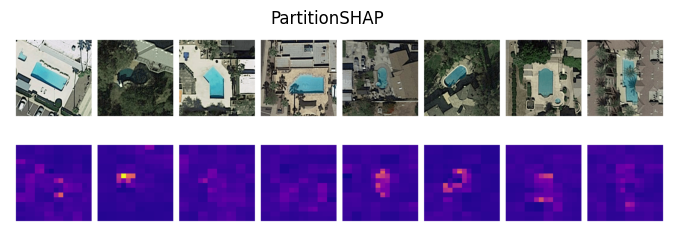

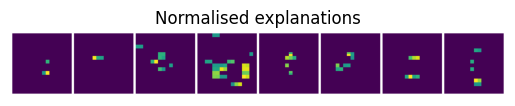

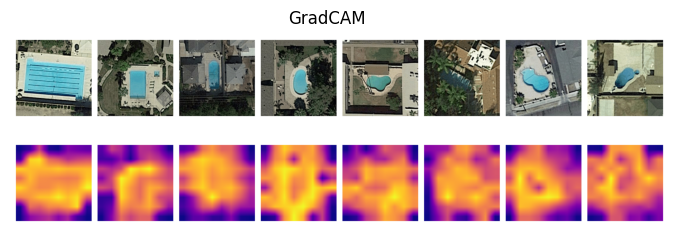

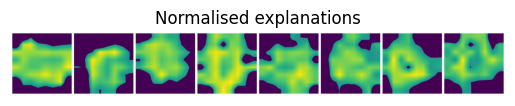

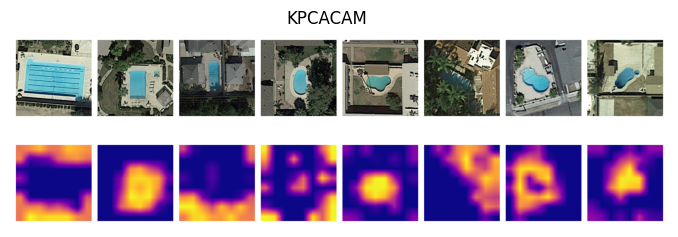

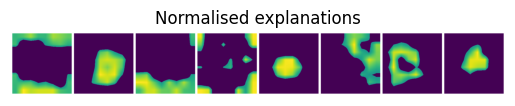

In [138]:
class_idx = 34
batch_num = 0

for e_name in t.get_args(xai.EXPLAINER_NAMES):
    exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
    )
    exp.force_load()
    exp.explanation = exp.explanation[:8]
    helpers.plotting.visualise_importance(exp.input[:8],
                                          exp.explanation, alpha=0.5, final_fig_size=(10, 2.5),
                                          with_colorbar=False, show_samples_separate=True)
    plt.suptitle(e_name)
    plt.show()
    visualise_compactness(exp)

In [159]:
print(list(enumerate(dataset.classes)))

[(0, 'airplane'), (1, 'baseball_field'), (2, 'basketball_court'), (3, 'beach'), (4, 'bridge'), (5, 'cemetery'), (6, 'chaparral'), (7, 'christmas_tree_farm'), (8, 'closed_road'), (9, 'coastal_mansion'), (10, 'crosswalk'), (11, 'dense_residential'), (12, 'ferry_terminal'), (13, 'football_field'), (14, 'forest'), (15, 'freeway'), (16, 'golf_course'), (17, 'harbor'), (18, 'intersection'), (19, 'mobile_home_park'), (20, 'nursing_home'), (21, 'oil_gas_field'), (22, 'oil_well'), (23, 'overpass'), (24, 'parking_lot'), (25, 'parking_space'), (26, 'railway'), (27, 'river'), (28, 'runway'), (29, 'runway_marking'), (30, 'shipping_yard'), (31, 'solar_panel'), (32, 'sparse_residential'), (33, 'storage_tank'), (34, 'swimming_pool'), (35, 'tennis_court'), (36, 'transformer_station'), (37, 'wastewater_treatment_plant')]


In [163]:
seleceted_classes = [1, 4, 17, 18, 28, 34, 35, 37]
exps = []
for class_idx in seleceted_classes:
    exp = xai.get_explainer_object(
        "GradCAM", model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{0:03}",
    )
    exp.force_load()
    exps.append(exp)

combined_exp = exp = xai.get_explainer_object(
    "GradCAM", model,
)
exp.input = torch.stack([e.input[0] for e in exps])
exp.explanation = np.stack([e.explanation[0] for e in exps])

0.41, 0.44, 0.46, 0.46, 0.25, 0.34, 0.29, 0.40


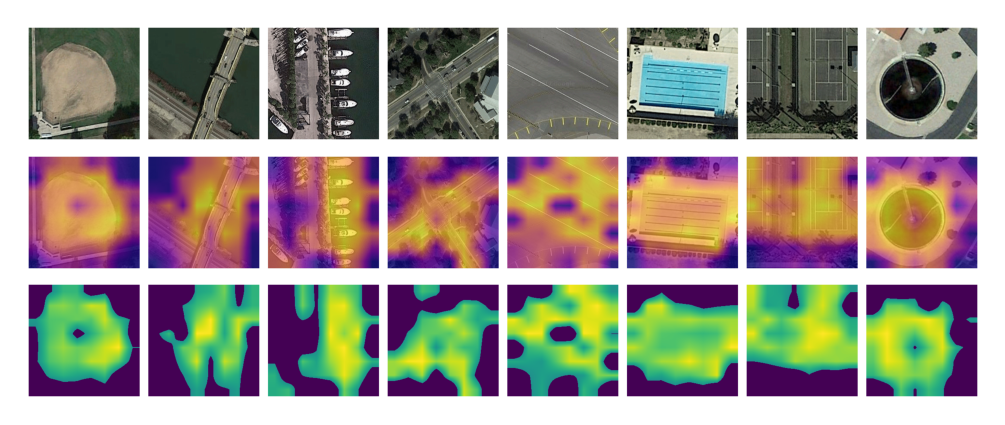

In [171]:
fig, axes = plt.subplots(3, 1, figsize=(10, 2.5))

helpers.plotting.show_image(exp.input,  ax=axes[0], padding_value=1, padding=20)

helpers.plotting.visualise_importance(exp.input, exp.explanation,
                                      alpha=0.7, ax=axes[1],
                                      with_colorbar=False)

abs_exp = np.abs(exp.explanation)  # negative values also contribute to visual clutter
norm_exp: np.ndarray = abs_exp / abs_exp.max(axis=(1, 2), keepdims=True)
norm_exp[norm_exp < 0.5] = 0.

# add fake colour channel for show_image's expected format: (n, c, h, w)
helpers.plotting.show_image(plt.get_cmap("viridis")(norm_exp)[...,:3],  ax=axes[2],
                            padding_value=1, padding=20, is_01_normalised=True)
print(", ".join([f"{s:.2f}" for s in np.sum(norm_exp==0, axis=(1, 2))/norm_exp[0].size]))

fig.subplots_adjust(hspace=0, wspace=0)
fig.set_dpi(200)
plt.show()